In [1]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import traceback
import pickle
from print_progress import print_progress

class RollingAverage:
    def __init__(self, n):
        self.n = n
        self.head = 0
        self.window = np.zeros(n)

    def push(self, val):
        self.window[self.head] = val
        self.head += 1
        self.head %= self.n
        
    def maxh(self):
        maxi = 0
        for i in range(self.n):
            if self.window[i] > maxi and self.window[i] != 1:
                maxi = self.window[i]
        return maxi

    def mean(self):
        for i in range(self.n):
            if self.maxh() > 0 and self.window[i] != 1:
                self.window[i] = self.window[i] / self.maxh()
        return np.mean(self.window)
    
    def mean2(self):
        summ = 0
        for i in range(self.n):
            if self.window[i] > 0:
                summ += 1
        return summ / self.n
    

    
def rk45(odefun, tspan, yini, options):
    """
    Runge-Kutta-Fehlberg 4(5) implementation for autonomous systems
    +------------++------------+------------+------------+------------+------------+------------+
    |     0      ||            |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/4     ||    1/4     |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    3/8     ||    3/32    |    9/32    |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |   12/13    || 1932/2197  | -7200/2197 | 7296/2197  |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |     1      ||  439/216   |     -8     |  3680/513  | -845/4104  |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/2     ||   -8/27    |     2      | -3544/2565 | 1859/4104  |   -11/40   |            |
    +------------++------------+------------+------------+------------+------------+------------+
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(5)    ||   16/135   |     0      | 6656/12825 |28561/56430 |   -9/50    |    2/55    |
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(4)    ||   25/216   |     0      | 1408/2565  | 2197/4104  |    -1/5    |     0      |
    +------------++------------+------------+------------+------------+------------+------------+
    """

    try:
        c       = np.zeros(6)
        c[:]    = [      0      ,     1/4    ,     3/8    ,    12/13   ,     1      ,     1/2    ]

        a       = np.zeros((6, 6))
        a[:,:]  = [[     0      ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    1/4     ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    3/32    ,    9/32    ,      0     ,      0     ,      0     ,      0     ],
                   [ 1932/2197  , -7200/2197 , 7296/2197  ,      0     ,      0     ,      0     ],
                   [  439/216   ,     -8     ,  3680/513  , -845/4104  ,      0     ,      0     ],
                   [   -8/27    ,     2      , 3544/2565 , 1859/4104  ,   -11/40   ,      0     ]]


        b       = np.zeros((2, 6))
        b[:,:]  = [[   16/135   ,     0      , 6656/12825 ,28561/56430 ,   -9/50    ,    2/55    ],
                   [   25/216   ,     0      , 1408/2565  , 2197/4104  ,    -1/5    ,     0      ]]

        # store the number of variables
        n       = len(yini)
        nstages = 6

        # check the existence of abstol and reltol
        if 'abstol' in options:
            abstol = options['abstol']
        else:
            abstol = 1.0e-4

        if 'reltol' in options:
            reltol = options['reltol']
        else:
            reltol = 1.0e-4

        # check for the existence of count of checkpoints
        if 'numcheckpoints' in options:
            numcheckpoints = options['numcheckpoints']
        else:
            numcheckpoints = 10

        # reset values of nacc and nrej
        options['nacc'] = 0
        options['nrej'] = 0

        # now divide up the interval with numcheckpoints
        timepoints = np.linspace(tspan[0], tspan[1], numcheckpoints + 1)

        print(timepoints)

        # create solution trajectory
        trajectory = np.zeros((n, numcheckpoints + 1))

        # store the initial solution
        trajectory[:, 0] = yini

        # stage values
        Y = np.zeros((n, nstages))

        # f values
        K = np.zeros((n, nstages))

        # store yini and compute fini
        Y[:, 0] = yini
        K[:, 0] = odefun(Y[:, 0])

        # Get h value from options if it exists
        if 'h' in options:
            h = options['h']
        else:
            h = 1.0e-3

        # get the machine epsilon
        eps = np.spacing(1)

        # rounding
        roundoff = eps/2.0
            
        # get the initial time
        t   = tspan[0]

        # get the final time
        tf  = tspan[1]

        # index for comparison against timepoints
        # to store trajectory when it exceeds this
        # or equals it
        i   = 0

        # safety factor
        fac = 0.8

        # Get hold of the model
        # expect a function model.train(X, y)
        # and model.predict(X)
        if 'model' in options:
            model = options['model']
        else:
            raise "Need an online model with train and predict methods."
        
        # number of variables to observe
        if 'nobservations' in options:
            nobs = options['nobservations']
        else:
            nobs = max(10, int(0.01 * n))
            
        # create training mask by randomly selecting
        # variables to observe
        if 'mask' in options:
            mask = options['mask']
        else:
            mask = np.rint(np.linspace(0, n - 1, min(n, nobs))).astype(int)
            print(mask)

        # Get hold of validation window size
        # window and success threshold
        if 'nvalidation' in options:
            nvalidation = options['nvalidation']
        else:
            nvalidation = 10

        # create a validation window
        # push one whenever prediction turned out to be
        # true otherwise push zero
        validation_window = RollingAverage(nvalidation)

        # only if the validation window has atleast
        # threshold number of successes will the
        # model be used to predict.
        if 'valthreshold' in options:
            valthreshold = options['valthreshold']
        else:
            valthreshold = 0.60

        # a constant by which to shrink stepsize if next step
        # is predicted to be rejected.
        if 'shrinkfactor' in options:
            shrinkfactor = options['shrinkfactor']
        else:
            shrinkfactor = 0.8

        # maxtimes to shrink stepsize if next step
        # is predicted to be rejected.
        if 'maxshrinks' in options:
            maxshrinks = options['maxshrinks']
        else:
            maxshrinks = 5

        # Store nsamples window of past features and data
        if 'nsamples' in options:
            nsamples = options['nsamples']
        else:
            nsamples = 10

        # Create feature variable with nsamples
        # and additional feature for step size
        featureX    = np.zeros((1, len(mask) + 1))

        # For accept signal
        signalYAcc  = np.zeros(nsamples)
        featureXAcc = np.zeros((nsamples, len(mask) + 1))
        countAcc    = 0
        indexAcc    = 0

        # For reject signal
        signalYRej  = np.zeros(nsamples)
        featureXRej = np.zeros((nsamples, len(mask) + 1))
        countRej    = 0
        indexRej    = 0

        # Minimum number of training samples
        if 'minsamples' in options:
            minsamples = options['minsamples']
        else:
            minsamples = nsamples
            
        # past prediction
        acceptnext = None

        # Step size stats
        steps      = []

        # Successful model predictions
        nvalid_models = []
        
        while tf - t - roundoff >= 0:
            # print a progress bar to track stuff
            print_progress(int(t/tf*100), 100)
            
            if tf - t <= 10 * roundoff * abs(tf):
                break
            
            for s in range(nstages - 1):
                Y[:, s + 1] = Y[:, 0] + h * K.dot(a[s + 1, :])
                K[:, s + 1] = odefun(Y[:, s + 1])

            # final output and error
            yfin = Y[:, 0] + h * K.dot(b[0, :])
            yerr = h * K.dot((b[0, :] - b[1, :]))
            
            # find the scaling factor            
            sc   = abstol + np.maximum(np.abs(Y[:, 0]), np.abs(yfin)) * reltol

            # compute the error
            err  = max(np.sqrt(np.sum((yerr / sc)**2)/n), 1.0e-10)

            # accept or reject
            if err <= 1:
                # append stepsize for plotting later on
                steps.append((h, 1))
                
                # accept
                if acceptnext == True:
                    validation_window.push(h)
                else:
                    validation_window.push(0)
                    
                # train
                # append accept signal
                featureXAcc[indexAcc, :-1] = Y[mask, 0]
                featureXAcc[indexAcc, -1]  = h
                signalYAcc[indexAcc]       = 1            # accept signal
                countAcc                  += 1
                indexAcc                  += 1
                countAcc                   = min(nsamples, countAcc)
                indexAcc                  %= nsamples     # replace oldest pair

                # Only train if min num of samples are met
                # and atleast one training signal of each class
                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    fX = np.vstack((featureXAcc[:countAcc,:], featureXRej[:countRej, :]))
                    sY = np.hstack((signalYAcc[:countAcc], signalYRej[:countRej]))
                    if __debug__:
                        print("Training Model")               
                    model.train(fX, sY)
                
                # now store the final output as next step ini
                Y[:, 0] = yfin
                K[:, 0] = odefun(Y[:, 0])
            
                # store the solution
                if t + h - timepoints[i + 1] >= 0 or tf - t - h <= 10 * roundoff * abs(tf):
                    i                = i + 1
                    trajectory[:, i] = yfin

                # increment time by h
                t = t + h

                # increment the count of accepted steps
                options['nacc'] += 1

                # compute the new h for next timestep
                h = h * min(1.5, max(0.2, fac * (1/err)**(1/5)))
                #h = max(h, validation_window.maxh()) - not working good

                # Only predict if you have already trained
                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    # construct new feature with new h and Y value
                    featureX[0,:-1] = Y[mask, 0]
                    featureX[0, -1] = h
                    if __debug__:
                        print("Validating Model")                 
                    # prediction and validation
                    sY         = model.predict(featureX)
                    acceptnext = (sY == 1)

                # model is somewhat trustworthy
                # if next step won't be accepted,
                # shrink stepsize by shrink constant
                # test for step acceptance
                if validation_window.mean() > valthreshold:
                    nvalid_models.append(1)
                    if __debug__:
                        print("Using Model for Prediction")
                    if not acceptnext:
                        for j in range(maxshrinks):
                            h *= shrinkfactor
                            featureX[0, -1] = h
                            acceptnext = (model.predict(featureX) == 1)

                            if acceptnext:
                                break
                    
                    else:
                        #probably 'h' can be bigger and accepted
                        h1 = h
                        h2 = h
                        featureX1 = featureX
                        h1 += h1/15
                        h1 = max(h1,validation_window.maxh())
                        featureX1[0, -1] = h1
                        acceptnext1 = (model.predict(featureX1) == 1)
                        if acceptnext1:
                            featureX[0, -1] = h1
                            h = h1
                    
                        
                else:
                    nvalid_models.append(0)
            else:
                # append stepsize for plotting later on
                steps.append((h, 0))
                
                # reject
                if acceptnext == False:
                    validation_window.push(1)
                else:
                    validation_window.push(0)
                    
                # train
                # append reject signal
                featureXRej[indexRej, :-1] = Y[mask, 0]
                featureXRej[indexRej, -1]  = h
                signalYRej[indexRej]       = 0            # reject signal
                countRej                  += 1
                indexRej                  += 1
                countRej                   = min(nsamples, countRej)
                indexRej                  %= nsamples     # replace oldest pair

                # Only train if min num of samples are met
                # and atleast one training signal of each class
                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    fX = np.vstack((featureXAcc[:countAcc,:], featureXRej[:countRej, :]))
                    sY = np.hstack((signalYAcc[:countAcc], signalYRej[:countRej]))
                    if __debug__:
                        print("Training Model")                
                    model.train(fX, sY)

                # increment the count of rejected steps
                options['nrej'] += 1
               
                # compute the new h for next timestep
                h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))
                #h = max(h, validation_window.maxh()) - not working good

                if countAcc > 0 and countRej > 0 and (countAcc + countRej) > minsamples:
                    # construct new feature with new h 
                    featureX[0, -1]  = h
                    if __debug__:
                        print("Validating Model")
                    # prediction and validation
                    sY         = model.predict(featureX)
                    acceptnext = (sY == 1)
                
                # model is somewhat trustworthy
                # if next step won't be accepted,
                # shrink stepsize by shrink constant
                if validation_window.mean() > valthreshold:
                    nvalid_models.append(1)
                    if __debug__:
                        print("Using Model for Prediction")
                    if not acceptnext:
                        for j in range(maxshrinks):
                            h *= shrinkfactor
                            featureX[0, -1] = h
                            acceptnext = (model.predict(featureX) == 1)

                            if acceptnext:
                                break
                    
                    else: #нужно протестировать!!!
                        #probably 'h' can be bigger and accepted
                        h1 = h
                        h2 = h
                        featureX1 = featureX
                        h1 += h1/15
                        h1 = max(h1,validation_window.maxh())
                        featureX1[0, -1] = h1
                        acceptnext1 = (model.predict(featureX1) == 1)
                        if acceptnext1:
                            featureX[0, -1] = h1
                            h = h1
                        
                else:
                    nvalid_models.append(0)

        print("\nPickling statistics.")
        
        # dump statistics
        pickle.dump({'steps':steps, 'nvalid_models':nvalid_models}, open('stats.p','wb'))
        
        return trajectory[:, :i]
    except BaseException as e:
        print(traceback.print_exc())    


In [2]:
# -*- coding: utf-8 -*-
# from gist: https://gist.github.com/aubricus/f91fb55dc6ba5557fbab06119420dd6a
import sys

# Print iterations progress
def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar

    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()


In [3]:
import numpy as np
import functools as ft

def InitializeModel():
    #  Solves the Allen Cahn problem from 
    #  M.P. Calvo and A. Gerisch.
    #  Linearly implicit Runge-Kutta methods and approximate matrix 
    #  factorization. Applied Numerical Mathematics,
    #  53(2):183-200, 2005.

    # Parameters defining the RHS behavior.
    myalpha = 1
    mygamma = 10

    # Grid size in x and y
    M = 128
    N = 128

    # Suggested integration information.
    Tspan = np.array([0, 0.075])
    dt_integration = 0.002

    # linear representation of x and y variables
    x = np.linspace(0,1,M)
    y = np.linspace(0,1,N)

    # Grid representation of x and y.
    X, Y = np.meshgrid(x,y)

    # grid representation of initial condition.
    u0 = 0.4 + 0.1 * (X + Y) + 0.1 * (np.sin(10*X) * np.sin(20*Y))
    
    # grid representation of boundary values corresponding to the intitial condition.
    bound  = lambda i,j,dx,dy: (0.4 + 0.1 * ((j - 1) * dx + (i - 1) * dy) + 
                               0.1 * (np.sin(10 * (j - 1) * dx) * np.sin(20 * (i - 1) *dy)))

    # linear representation of initial condition.
    y0     = np.reshape(u0, M*N)
    
    # RHS and Jacobian function calls, in MATLAB standard form.
    rhsFun = ft.partial(AllenCahnNeumann, M=M, N=N, alpha=myalpha, gamma=mygamma, bound=bound)

    model  = {'rhsFun': rhsFun,
             'y0':     y0,
             'Tspan':  Tspan,
             'dt':     dt_integration,
             'M':      M,
             'N':      N,
             'alpha':  myalpha,
             'gamma':  mygamma}

    return model
             
    
def AllenCahnNeumann(u, M, N, alpha, gamma, bound):
    dx = 1.0/(N-1)
    dy = 1.0/(M-1)
    f  = np.zeros(M*N)
    
    for i in range(1, M+1):
        for j in range(1, N+1):        
            self = i + M * (j - 1) - 1 

            if ( i == 1 ):
                down = u[self] - dy * bound(i, j, dx, dy)
            else:
                down = u[i - 1 + M * (j - 1) - 1]
                
            if ( i == M ):
                up = u[self] + dy * bound(i,j,dx,dy)
            else:
                up = u[i + 1 + M * (j - 1) - 1]
        
            if ( j == 1 ):
                left = u[self] - dx * bound(i,j,dx,dy)
            else:
                left = u[i + M * (j - 2) - 1]
        
            if ( j == N ):
                right = u[self] + dx * bound(i,j,dx,dy)

            else:
                right = u[i + M * j - 1]
        
            uself = u[self]

            f[self] = alpha * (1.0/dy**2 * (up    - 2 * uself + down)  + \
                               1.0/dx**2 * (right - 2 * uself + left)) + gamma * (uself - uself**3)
            
    return f

[0.     0.0003 0.0006 ... 0.2994 0.2997 0.3   ]
[    0   683  1365  2048  2730  3413  4096  4778  5461  6144  6826  7509
  8192  8874  9557 10239 10922 11605 12287 12970 13652 14335 15018 15700
 16383]
 |----------------------------------------------------------------------------------------------------| 0.0% 0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% 0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0%

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
5.873913691412407e-07
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
5.914744016764657e-07
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
5.955779700605881e-07
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
5.997018119883245e-07
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
6.038456600999474e-07
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
6.080092421588719e-07
Validatin

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0311144500912662e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0358695592888286e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0406201290054438e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0453659830725887e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.050106947043102e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.0548428481989653e-06
Vali

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.4480493357281653e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.4518416045960244e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.4556213754127386e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.459388658584237e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.463143466001535e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.4668858110179666e-06
Valid

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7601513178592002e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7629294707910602e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.765699818780347e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.768462423013828e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7712173445357728e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.7739646442493404e-06
Valid

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
1.9993054189583784e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.0015816441576607e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.0038548672128486e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.00612512536428e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.0083924556062223e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.010656894688445e-06
Valida

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2087234902923034e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2108508866182225e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.212977936298865e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2151046593395893e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2172310756291446e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.2193572049396938e-06
Vali

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.4139004797107945e-06
Validating Model
0.2
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.4160721921285673e-06
Validating Model
0.2
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.4182450735239842e-06
Validating Model
0.2
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.420419136554529e-06
Validating Model
0.2
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.4225943938356143e-06
Validating Model
0.3
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.4247708579388637e-06
Vali

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.6294054575186145e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.6317422923353016e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.634081371640988e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.636422705709386e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.6387663048090395e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.641112179199386e-06
Valida

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8654285808575836e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.868027203508208e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8706290476829717e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8732341237742704e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8758424421847096e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
2.8784540133305847e-06
Vali

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.1311165566809106e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.134073889795667e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.137035513612618e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.140001440277017e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.1429716819589483e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.1459462508613792e-06
Valida

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.436418530992137e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4398474466223973e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4432819622638573e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.446722093354183e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4501678553767573e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.4536192638584136e-06
Valid

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.793493448793697e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.7975372793903122e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.8015884213347732e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.8056468952648803e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.8097127218849174e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
3.8137859219674674e-06
Vali

 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.21823063317204e-06
Validating Model
0.2
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.22308105517152e-06
Validating Model
0.1
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.227941120477782e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.232810857663701e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.237690295408387e-06
Validating Model
0.0
0
 |----------------------------------------------------------------------------------------------------| 0.0% Training Model
4.242579462504535e-06
Validating 

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.7322949109816705e-06
Validating Model
0.1
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.738217551746485e-06
Validating Model
0.1
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.744153114290522e-06
Validating Model
0.1
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.750101639323533e-06
Validating Model
0.1
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.756063167709034e-06
Validating Model
0.1
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
4.762037740468066e-06
Validati

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.366172641994135e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.3735462465365045e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.380937504736936e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.388346476016536e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.395773220037409e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
5.403217796694763e-06
Validati

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.16390464816905e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.173282482301557e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.182684951979359e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.192112145616012e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.201564151984445e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
6.211041060233345e-06
Validating

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.190495904772867e-06
Validating Model
0.1
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.202701168035262e-06
Validating Model
0.1
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.21494151351434e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.227217073812563e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.239527982115282e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
7.251874372107097e-06
Validating

 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.543088741899211e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.55935249181012e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.575666864814724e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.592032055344085e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.608448258552254e-06
Validating Model
0.0
0
 |█---------------------------------------------------------------------------------------------------| 1.0% Training Model
8.624915670321304e-06
Validating

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0365399616033942e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.038751087395586e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0409694584610597e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.043195100508691e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0454280392927423e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.0476683006130165e-05
Valid

 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2855985511340418e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2886247965587272e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2916607680850565e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2947064886657401e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.2977619811073693e-05
Validating Model
0.0
0
 |██--------------------------------------------------------------------------------------------------| 2.0% Training Model
1.3008272680672382e-05
Val

 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.6230202295542136e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.6270504953597384e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.631091429284893e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.6351430205466547e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.639205257794059e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
1.643278129115638e-05
Valida

 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.054941173456267e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.0598555666022318e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.0647766763107475e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.069704431817875e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.074638761914352e-05
Validating Model
0.0
0
 |███-------------------------------------------------------------------------------------------------| 3.0% Training Model
2.0795795949250537e-05
Valida

 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.5463197971234166e-05
Validating Model
0.0
0
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.551524284900586e-05
Validating Model
0.0
0
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.5567280761136675e-05
Validating Model
0.0
0
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.5619311034482776e-05
Validating Model
0.0
0
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.5671333000733862e-05
Validating Model
0.0
0
 |████------------------------------------------------------------------------------------------------| 4.0% Training Model
2.5723345996104296e-05
Vali

 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.0349302483263985e-05
Validating Model
0.0
0
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.0398367548009466e-05
Validating Model
0.0
0
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.0447384578792713e-05
Validating Model
0.0
0
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.0496353348553454e-05
Validating Model
0.0
0
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.054527363198554e-05
Validating Model
0.0
0
 |█████-----------------------------------------------------------------------------------------------| 5.0% Training Model
3.059414520564231e-05
Valid

 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.4810444209065744e-05
Validating Model
0.0
0
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.4853921130945553e-05
Validating Model
0.0
0
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.4897327946936874e-05
Validating Model
0.0
0
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.494066434707998e-05
Validating Model
0.0
0
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.498393001891376e-05
Validating Model
0.0
0
 |██████----------------------------------------------------------------------------------------------| 6.0% Training Model
3.5027124647461984e-05
Valid

 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.341906733388408e-05
Validating Model
0.0
0
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.342403671541012e-05
Validating Model
0.0
0
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.3398965926762e-05
Validating Model
0.0
0
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.3360389198439975e-05
Validating Model
0.0
0
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.333301460771838e-05
Validating Model
0.0
0
 |███████---------------------------------------------------------------------------------------------| 7.0% Training Model
3.3333702574351725e-05
Validatin

 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.332191292349767e-05
Validating Model
0.0
0
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.327743365932423e-05
Validating Model
0.0
0
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.3296846443186004e-05
Validating Model
0.0
0
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.336770471919838e-05
Validating Model
0.0
0
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.343531814033168e-05
Validating Model
0.0
0
 |████████--------------------------------------------------------------------------------------------| 8.0% Training Model
3.3444859976867286e-05
Validat

 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.2031059672879036e-05
Validating Model
0.0
0
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.485674377048416e-05
Validating Model
0.0
0
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.674460334140961e-05
Validating Model
0.0
0
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.6713251864076435e-05
Validating Model
0.0
0
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.3962350105136855e-05
Validating Model
0.0
0
 |█████████-------------------------------------------------------------------------------------------| 9.0% Training Model
3.0462469839971915e-05
Valid

 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.910624904343775e-05
Validating Model
0.1
0
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.5065539827770244e-05
Validating Model
0.1
0
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
2.9361284735830223e-05
Validating Model
0.1
0
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
2.740044989943796e-05
Validating Model
0.1
0
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.143826618669084e-05
Validating Model
0.0
0
 |██████████------------------------------------------------------------------------------------------| 10.0% Training Model
3.5762119299415365e-05


 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.899151313658354e-05
Validating Model
0.0
0
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
4.03904399196501e-05
Validating Model
0.0
0
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.849043950600532e-05
Validating Model
0.0
0
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
3.1969441481790793e-05
Validating Model
0.0
0
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
2.6968956714199653e-05
Validating Model
0.0
0
 |███████████-----------------------------------------------------------------------------------------| 11.0% Training Model
2.8142419834336817e-05
V

 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.176084044730639e-05
Validating Model
0.0
0
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
2.779992770380646e-05
Validating Model
0.0
0
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
2.9246180005001204e-05
Validating Model
0.0
0
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.421118409004593e-05
Validating Model
0.0
0
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
3.78093331982683e-05
Validating Model
0.0
0
 |████████████----------------------------------------------------------------------------------------| 12.0% Training Model
4.0004926206592317e-05
Va

 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.1885612507176926e-05
Validating Model
0.1
0
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.632551388609455e-05
Validating Model
0.1
0
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
3.927986580170782e-05
Validating Model
0.1
0
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.1165772914887864e-05
Validating Model
0.1
0
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.23397454506654e-05
Validating Model
0.1
0
 |█████████████---------------------------------------------------------------------------------------| 13.0% Training Model
4.3056809151237396e-05
V

 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.013407220709525e-05
Validating Model
0.0
0
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
4.136139773794551e-05
Validating Model
0.0
0
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.96190943708156e-05
Validating Model
0.0
0
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
3.245999283568185e-05
Validating Model
0.0
0
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.6565314063131506e-05
Validating Model
0.0
0
 |██████████████--------------------------------------------------------------------------------------| 14.0% Training Model
2.717849564356312e-05
Val

 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.384944592870971e-05
Validating Model
0.0
0
 |███████████████-------------------------------------------------------------------------------------| 15.0% Training Model
3.745582987385981e-05
Validating Model
0.0
0
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.9579973553572186e-05
Validating Model
0.0
0
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.9235657229610876e-05
Validating Model
0.0
0
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
3.409525038848319e-05
Validating Model
0.0
0
 |████████████████------------------------------------------------------------------------------------| 16.0% Training Model
2.8306843083047815e-05


 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.2270337552705765e-05
Validating Model
0.1
0
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.279605730394763e-05
Validating Model
0.1
0
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
4.0993022694830924e-05
Validating Model
0.1
0
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
Validating Model
0.1
0
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
2.6085324255718615e-05
Validating Model
0.1
0
 |█████████████████-----------------------------------------------------------------------------------| 17.0% Training Model
2.574903508127779e-05
Validating Model
0.1
0

 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.2730319862525654e-05
Validating Model
0.0
0
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.6837098073845045e-05
Validating Model
0.0
0
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
3.954366802904829e-05
Validating Model
0.0
0
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.126114437792575e-05
Validating Model
0.0
0
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.232148030954481e-05
Validating Model
0.0
0
 |██████████████████----------------------------------------------------------------------------------| 18.0% Training Model
4.2881265356738486e-05


 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.2838262966694074e-05
Validating Model
0.0
0
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.6613826579167198e-05
Validating Model
0.0
0
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
2.6823113828864476e-05
Validating Model
0.0
0
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.2658916067296256e-05
Validating Model
0.0
0
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.679194684337804e-05
Validating Model
0.0
0
 |███████████████████---------------------------------------------------------------------------------| 19.0% Training Model
3.951781099011365e-05

 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
2.739196870693419e-05
Validating Model
0.0
0
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
2.6820124922555143e-05
Validating Model
0.0
0
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.246186857019428e-05
Validating Model
0.0
0
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.6671337330620056e-05
Validating Model
0.0
0
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
3.945265552523814e-05
Validating Model
0.0
0
 |████████████████████--------------------------------------------------------------------------------| 20.0% Training Model
4.1197835062335224e-05


 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
4.112127698880713e-05
Validating Model
0.0
0
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.7456163561772364e-05
Validating Model
0.0
0
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.0035436962635613e-05
Validating Model
0.0
0
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.6020856815542566e-05
Validating Model
0.0
0
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
2.9412410461967555e-05
Validating Model
0.0
0
 |█████████████████████-------------------------------------------------------------------------------| 21.0% Training Model
3.459353598371703e-05

 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.5728367266843464e-05
Validating Model
0.0
0
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.9095682562764574e-05
Validating Model
0.0
0
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
2.6557023040861235e-05
Validating Model
0.0
0
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.101931357897487e-05
Validating Model
0.0
0
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.5745884376123065e-05
Validating Model
0.0
0
 |██████████████████████------------------------------------------------------------------------------| 22.0% Training Model
3.892245682297073e-05

 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.657675592912511e-05
Validating Model
0.0
0
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.008548887584721e-05
Validating Model
0.0
0
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
2.6768842876900347e-05
Validating Model
0.0
0
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.014852357376229e-05
Validating Model
0.0
0
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.5170307677541265e-05
Validating Model
0.0
0
 |███████████████████████-----------------------------------------------------------------------------| 23.0% Training Model
3.8591504032286425e-05


 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.1404732279738616e-05
Validating Model
0.0
0
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.6643716766414622e-05
Validating Model
0.0
0
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
2.8468731435420836e-05
Validating Model
0.0
0
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.4034125075630334e-05
Validating Model
0.0
0
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
3.791086899892159e-05
Validating Model
0.0
0
 |████████████████████████----------------------------------------------------------------------------| 24.0% Training Model
4.043750855811776e-05

 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.3975651415579775e-05
Validating Model
0.0
0
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.511462297159501e-05
Validating Model
0.0
0
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.481152513753716e-05
Validating Model
0.0
0
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.303665801084907e-05
Validating Model
0.0
0
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.135223620537755e-05
Validating Model
0.0
0
 |█████████████████████████---------------------------------------------------------------------------| 25.0% Training Model
3.151299014784727e-05
Va

 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
4.108623927330184e-05
Validating Model
0.0
0
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
Validating Model
0.1
0
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.88198629143524e-05
Validating Model
0.1
0
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
2.859781156399599e-05
Validating Model
0.1
0
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.328713933185223e-05
Validating Model
0.1
0
 |██████████████████████████--------------------------------------------------------------------------| 26.0% Training Model
3.739564574294905e-05
Validating Model
0.1
0
 |█

 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.183729890610744e-05
Validating Model
0.0
0
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.3676177861735195e-05
Validating Model
0.0
0
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.5496280676747605e-05
Validating Model
0.0
0
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.5695027534608406e-05
Validating Model
0.0
0
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.366322701326985e-05
Validating Model
0.0
0
 |███████████████████████████-------------------------------------------------------------------------| 27.0% Training Model
3.107305044174821e-05


 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.772894329123924e-05
Validating Model
0.1
0
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.043617303023827e-05
Validating Model
0.1
0
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
4.063246043451645e-05
Validating Model
0.1
0
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
3.4970954152232e-05
Validating Model
0.1
0
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.7981695910003836e-05
Validating Model
0.1
0
 |████████████████████████████------------------------------------------------------------------------| 28.0% Training Model
2.6160632820539155e-05
Val

 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
2.9898755145884297e-05
Validating Model
0.2
0
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.3432483513823944e-05
Validating Model
0.1
0
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.708122790724035e-05
Validating Model
0.1
0
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.873078826776779e-05
Validating Model
0.1
0
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.631536345500563e-05
Validating Model
0.1
0
 |█████████████████████████████-----------------------------------------------------------------------| 29.0% Training Model
3.084622508343892e-05
V

 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.0577458472565944e-05
Validating Model
0.0
0
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.218332113381476e-05
Validating Model
0.0
0
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.5247859647330056e-05
Validating Model
0.0
0
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.7160847784649696e-05
Validating Model
0.0
0
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.606289789576103e-05
Validating Model
0.0
0
 |██████████████████████████████----------------------------------------------------------------------| 30.0% Training Model
3.213121634960855e-05


 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.10670306684324e-05
Validating Model
0.1
0
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.090239198832091e-05
Validating Model
0.1
0
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.341153882838801e-05
Validating Model
0.1
0
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.6280840354498883e-05
Validating Model
0.1
0
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.714813774481285e-05
Validating Model
0.1
0
 |███████████████████████████████---------------------------------------------------------------------| 31.0% Training Model
3.45421838043431e-05
Vali

 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
2.9181847312675515e-05
Validating Model
0.2
0
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
2.9103482071393186e-05
Validating Model
0.1
0
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
3.3764946164047e-05
Validating Model
0.1
0
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
3.810139771665203e-05
Validating Model
0.1
0
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
4.035115775345854e-05
Validating Model
0.1
0
 |████████████████████████████████--------------------------------------------------------------------| 32.0% Training Model
3.790963953652102e-05
Val

 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.3633459614758926e-05
Validating Model
0.1
0
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.363953573496468e-05
Validating Model
0.1
0
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.333254903252242e-05
Validating Model
0.1
0
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.2981170519221974e-05
Validating Model
0.1
0
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.2960694771728176e-05
Validating Model
0.1
0
 |█████████████████████████████████-------------------------------------------------------------------| 33.0% Training Model
3.3362949803653245e-05

 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.220463390930397e-05
Validating Model
0.0
0
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.702488875583e-05
Validating Model
0.0
0
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.9966733461105446e-05
Validating Model
0.0
0
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.855376298383269e-05
Validating Model
0.0
0
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
3.193624167659877e-05
Validating Model
0.0
0
 |██████████████████████████████████------------------------------------------------------------------| 34.0% Training Model
2.685185550029311e-05
Valid

 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.1121070197190626e-05
Validating Model
0.1
0
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.070964189881176e-05
Validating Model
0.1
0
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.3262607139688704e-05
Validating Model
0.1
0
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.647100236546971e-05
Validating Model
0.0
0
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.7501513584918875e-05
Validating Model
0.0
0
 |███████████████████████████████████-----------------------------------------------------------------| 35.0% Training Model
3.4579261665049094e-05

 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.209612083622948e-05
Validating Model
0.0
0
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.331334229467029e-05
Validating Model
0.0
0
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.4885783998929994e-05
Validating Model
0.0
0
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.518991920188857e-05
Validating Model
0.0
0
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.356614491421856e-05
Validating Model
0.0
0
 |████████████████████████████████████----------------------------------------------------------------| 36.0% Training Model
3.143910558568319e-05
Va

 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.350300652910265e-05
Validating Model
0.1
0
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
3.9021720064143455e-05
Validating Model
0.1
0
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.27618148659856e-05
Validating Model
0.1
0
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.517796054089272e-05
Validating Model
0.1
0
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.6694202743307064e-05
Validating Model
0.1
0
 |█████████████████████████████████████---------------------------------------------------------------| 37.0% Training Model
4.758181639533843e-05
Va

 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.3405110577524245e-05
Validating Model
0.0
0
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
2.889865387956423e-05
Validating Model
0.0
0
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
2.867716681347161e-05
Validating Model
0.0
0
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.412162431975352e-05
Validating Model
0.0
0
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
3.927001379053057e-05
Validating Model
0.0
0
 |██████████████████████████████████████--------------------------------------------------------------| 38.0% Training Model
4.1879223953997305e-05
V

 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.379936153428684e-05
Validating Model
0.1
0
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.946617019067181e-05
Validating Model
0.0
0
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
4.300728631372824e-05
Validating Model
0.0
0
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
Validating Model
0.1
0
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.2128345898305395e-05
Validating Model
0.1
0
 |███████████████████████████████████████-------------------------------------------------------------| 39.0% Training Model
3.212948198966438e-05
Validating Model
0.1
0
 

 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.456421867747173e-05
Validating Model
0.1
0
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.020620062845118e-05
Validating Model
0.1
0
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
4.362635615391904e-05
Validating Model
0.1
0
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.113217582280833e-05
Validating Model
0.2
0
 |████████████████████████████████████████------------------------------------------------------------| 40.0% Training Model
3.1184776721310836e-05
Validating Model
0.2
0
 

 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.6924719997638014e-05
Validating Model
0.2
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
Validating Model
0.2
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.023472824931796e-05
Validating Model
0.2
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.0417859414620226e-05
Validating Model
0.2
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.4388014934261866e-05
Validating Model
0.1
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.840134710897345e-05
Validating Model
0.1
0

 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.641363369573632e-05
Validating Model
0.0
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
Validating Model
0.1
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.731056332727519e-05
Validating Model
0.1
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
2.731536952406701e-05
Validating Model
0.1
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
3.486943523268379e-05
Validating Model
0.1
0
 |█████████████████████████████████████████-----------------------------------------------------------| 41.0% Training Model
4.0826302778715354e-05
Validating Model
0.1
0
 

 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.393528157777519e-05
Validating Model
0.2
0
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.3389975397615055e-05
Validating Model
0.2
0
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.265826016938138e-05
Validating Model
0.1
0
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.256685787193885e-05
Validating Model
0.1
0
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.341080142047386e-05
Validating Model
0.1
0
 |██████████████████████████████████████████----------------------------------------------------------| 42.0% Training Model
3.444727326624643e-05
Va

 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.1345716004561154e-05
Validating Model
0.1
0
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.572532474506498e-05
Validating Model
0.1
0
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
4.832971902875289e-05
Validating Model
0.1
0
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
2.983371556005216e-05
Validating Model
0.2
0
 |███████████████████████████████████████████---------------------------------------------------------| 43.0% Training Model
3.0108600002677788e-05
Validating Model
0.2
0


 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.266204265642719e-05
Validating Model
0.2
0
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.404525140218192e-05
Validating Model
0.1
0
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.5029289853767154e-05
Validating Model
0.1
0
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.4258440717192046e-05
Validating Model
0.1
0
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.224005654987976e-05
Validating Model
0.1
0
 |████████████████████████████████████████████--------------------------------------------------------| 44.0% Training Model
3.110120669495209e-05
V

 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.340390982945244e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.2957393055632987e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.286761003280659e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.335591955232454e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████-------------------------------------------------------| 45.0% Training Model
3.399579339213633e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
3.402737781950098e-05
Va

 |██████████████████████████████████████████████------------------------------------------------------| 46.0% Training Model
2.801924036866724e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.605435064902736e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
4.275056390805172e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
4.624290166686535e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
2.7389679485637794e-05
Validating Model
0.1
0
 

 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.1016842324503505e-05
Validating Model
0.0
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.131492784354665e-05
Validating Model
0.0
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.449261202752872e-05
Validating Model
0.0
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.754503475926104e-05
Validating Model
0.0
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.651546209292926e-05
Validating Model
0.0
0
 |███████████████████████████████████████████████-----------------------------------------------------| 47.0% Training Model
3.172091974652015e-05
Va

 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.874814015786551e-05
Validating Model
0.0
0
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.371946027253667e-05
Validating Model
0.0
0
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.816329974321024e-05
Validating Model
0.0
0
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
2.765382449044872e-05
Validating Model
0.0
0
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
3.5246511374331675e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████----------------------------------------------------| 48.0% Training Model
4.2535599866983206e-05
V

 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
3.626120937419257e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.352681919571345e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
4.7854370838161895e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
Validating Model
0.2
0
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.809530912230392e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████---------------------------------------------------| 49.0% Training Model
2.8305037376367935e-05
Validating Model
0.2
0


 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.2897805752647025e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.3638238284347175e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.4265981458021596e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.3915817812247945e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.275373793472193e-05
Validating Model
0.0
0
 |██████████████████████████████████████████████████--------------------------------------------------| 50.0% Training Model
3.2019291059843334e-0

 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.364801674808677e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.139602654542406e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.0993165987031885e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.367313729930751e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.72309974920862e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████-------------------------------------------------| 51.0% Training Model
3.714171014079835e-05
Val

 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.7822701980052777e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.8118775458016628e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.6782557282491876e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
4.455280233386029e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
Validating Model
0.3
0
 |███████████████████

 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.365672761056623e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.603882189094413e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.574912688583024e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.245634336055056e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
2.969155560294147e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████------------------------------------------------| 52.0% Training Model
3.078413994860753e-05
Val

 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.9220376218675592e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
2.9504847695548397e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.592071882349002e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
4.240998607062162e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
Validating Model
0.2
0
 |█████████████████████████████████████████████████████-----------------------------------------------| 53.0% Training Model
3.1049816007232746e-05
Validating Model
0.2
0

 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.297506133333679e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.4002433640708476e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.454040473143112e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.368330750760949e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.2166188809065296e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████----------------------------------------------| 54.0% Training Model
3.172626820262144e-05
V

 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.265607515395704e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.293129666150379e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.388934648268794e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.4485608723826377e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.377280993346081e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████---------------------------------------------| 55.0% Training Model
3.2316256063603325e-05
V

 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
5.350310119888873e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.636361397894937e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.732794402138813e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.3523356297066365e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.914133603315284e-05
Validating Model
0.1
0
 

 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
4.859329043020556e-05
Validating Model
0.0
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
Validating Model
0.1
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.8772170154429444e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
2.9167849748319273e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
3.672699186244549e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████--------------------------------------------| 56.0% Training Model
4.4237896940882986e-05
Validating Model
0.1
0

 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.3968711854111325e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.105549055422515e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.143373292561954e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.485672779546821e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.793885207829076e-05
Validating Model
0.1
0
 

 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.676667599892994e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.0416051307918355e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
2.6901884550630973e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
3.088669357312406e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.180170006009744e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████-------------------------------------------| 57.0% Training Model
4.971196369062004e-05
V

 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.08750559396361e-05
Validating Model
0.0
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.8346901592122343e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.8389294556068846e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.695094337828447e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.588351936957716e-05
Validating Model
0.1
0
 

 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.1577816310027216e-05
Validating Model
0.0
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.84932408038516e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
2.8576899338810653e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
3.688869568384564e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████------------------------------------------| 58.0% Training Model
4.566098779573424e-05
Validating Model
0.1
0
 

 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.0106971679890232e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.028395639790481e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.541525550320269e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
4.082223463254546e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████-----------------------------------------| 59.0% Training Model
3.0094347266343526e-05
Validating Model
0.2
0


 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
4.178072300644e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
2.980304238044478e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.001333080921482e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
3.576664013597066e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████----------------------------------------| 60.0% Training Model
4.183221337642068e-05
Validating Model
0.2
0
 |███

 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.9776455133860885e-05
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
3.6113439075919345e-05
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
4.279359732127979e-05
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.9521467498786747e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████---------------------------------------| 61.0% Training Model
2.9764703734214045e-05
Validating Model
0.3


 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.3
0
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.9280090788828282e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
2.955293665088162e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
3.648131797913099e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
4.378103468641389e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████--------------------------------------| 62.0% Training Model
Validating Model
0.2
0
 |█████████████████████

 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.683606588983347e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
4.4706053865378746e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.904795126800688e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
2.9350518069037484e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████-------------------------------------| 63.0% Training Model
3.685491446962408e-05
Validating Model
0.2
0


 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.8844818630341785e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.9174473375071552e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
3.7216927512597675e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
4.5673426290259895e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████------------------------------------| 64.0% Training Model
2.883454843668554e-05
Validating Model
0.2


 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.659140453228139e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.864670651500841e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
2.900385511084926e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
3.760685932833074e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████-----------------------------------| 65.0% Training Model
4.66397665203888e-05
Validating Model
0.2
0
 |█

 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.885407358263873e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
3.7986716937357475e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
4.7560676627400836e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.8462750865945697e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.8846497706860627e-05
Validating Model
0.2


 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.8299729422688244e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
2.8708023747937106e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████----------------------------------| 66.0% Training Model
3.839731560913245e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.8536265972606404e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
Validating Model
0.2
0
 |███████████████████

 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.8798161114318396e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
4.94712804310154e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
2.8139347958057312e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
2.857280502063886e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████---------------------------------| 67.0% Training Model
3.8819602620344625e-05
Validating Model
0.3
0


 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.800633631650579e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.8465961725613852e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
3.9215671118564594e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
5.041547119666371e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████--------------------------------| 68.0% Training Model
2.7975630841401475e-05
Validating Model
0.3
0

 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
5.2930475723981404e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.906875859838619e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
2.9798038075176653e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
3.7700771967501785e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████-------------------------------| 69.0% Training Model
4.501200984202605e-05
Validating Model
0.2
0

 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
2.7680277405959195e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
4.022273137812915e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
5.3858599597870234e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
2.912100369687689e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████------------------------------| 70.0% Training Model
2.9903002765379842e-05
Validating Model
0.2
0

 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
2.714612863752441e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
2.7381569663335236e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
4.1072354495002853e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
5.580796710723137e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████-----------------------------| 71.0% Training Model
Validating Model
0.2
0
 |████████████████████

 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
2.735169588041632e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
4.102754382062448e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
5.649855616842348e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.132718580991642e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████----------------------------| 72.0% Training Model
3.25621470137465e-05
Validating Model
0.3
0
 |█

 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.350898650649587e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.9439399771267987e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
2.9267076723283156e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
3.6182799257148306e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
4.488921468818248e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████---------------------------| 73.0% Training Model
Validating Model
0.1
0

 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
3.075626393534865e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
3.599717960075658e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
4.0736222713830394e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.8865568160177934e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████--------------------------| 74.0% Training Model
2.9005471184407607e-05
Validating Model
0.2
0

 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
4.170024956295121e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.965802150670041e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
2.991948317581754e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
3.644991399007006e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████-------------------------| 75.0% Training Model
4.3359268449040886e-05
Validating Model
0.2
0
 

 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.1505061516129094e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
5.7334763646617814e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.7994963074374857e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
2.87402817717067e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████------------------------| 76.0% Training Model
4.026689616636482e-05
Validating Model
0.2
0


 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.639898490952035e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.861071079567204e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.429435981572456e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.864567227429917e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
2.7585145915006675e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████-----------------------| 77.0% Training Model
3.639835966788518e-05
Va

 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
5.862266888874284e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.8429184942486213e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
2.930022085977252e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
3.9451256940234875e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████----------------------| 78.0% Training Model
4.8844985364180274e-05
Validating Model
0.2
0

 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.3154537553635944e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.5900330664585535e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.610125521973864e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.2696315104032656e-05
Validating Model
0.0
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
2.9519794331634807e-05
Validating Model
0.0
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.0405195024153017e-0

 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.8833777871086655e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
4.022303884141584e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
3.3109173238953284e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
2.6523310086492413e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████---------------------| 79.0% Training Model
2.6709565502014303e-05
Validating Model
0.1


 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.246383885402018e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.3181261137205866e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.4508163950561544e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.471310233005219e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.309478352324155e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████--------------------| 80.0% Training Model
3.1360627729342435e-05


 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.4509230499579545e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.3123794172265976e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.162794317964054e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.1967725548853515e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.4662151073556586e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████████-------------------| 81.0% Training Model
3.6860252863448946e-0

 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.174219037895716e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.6858962121919066e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.953792871894663e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.452579840350046e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.8109526252163477e-05
Validating Model
0.0
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
2.6816176919795066e-05


 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.250915371852262e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.1300395007572463e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.2523003693181096e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.586867071675948e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.7094198885630256e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████------------------| 82.0% Training Model
3.357690245460372e-05


 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
5.257137073646342e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.6663121947682308e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.7013044021247883e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.051956603187183e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
6.077934904780774e-05
Validating Model
0.2
0


 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
3.92549621941852e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
5.2167838023254445e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.652851151237598e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
2.6840642331045077e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████-----------------| 83.0% Training Model
4.0260963496567616e-05
Validating Model
0.2
0


 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.637347463571788e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
4.227254899710213e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.8313687446763422e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
2.8479768147757705e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.897856378744219e-05
Validating Model
0.2
0


 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.9960260282744776e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
4.003005576444923e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.255571068827876e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████████████████----------------| 84.0% Training Model
3.29739050914027e-05
Validating Model
0.3
0
 |██████████████████████

 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.288722918904368e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.623297945571753e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.683640894679713e-05
Validating Model
0.1
0
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
3.294601846240892e-05
Validating Model
0.0
0
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.9038625905806068e-05
Validating Model
0.0
0
 |█████████████████████████████████████████████████████████████████████████████████████---------------| 85.0% Training Model
2.957484134969234e-05
Va

 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.7547186544510895e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
4.68996219777207e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
2.7284038508806744e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
2.751885127748417e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
4.127827691622626e-05
Validating Model
0.2
0
 

 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.2292077332521485e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.277801595394581e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.438100346541749e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.520610143950568e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████--------------| 86.0% Training Model
3.370120513690312e-05
Validating Model
0.2
0
 

 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.6867333330245515e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
2.7152478122943506e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
4.0728717184415256e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
6.109307577662288e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████-------------| 87.0% Training Model
Validating Model
0.2
0
 |███████████████████

 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.476210149228459e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.976719012807455e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
2.8186930601503044e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
3.4166826592378174e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
4.722855739825839e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████------------| 88.0% Training Model
Validating Model
0.1
0


 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
4.7247237776768385e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.3719384219421124e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.4810268496246416e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.422027978289414e-05
Validating Model
0.2
0
 |███████████████████

 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.252585963092043e-05
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.306732213747919e-05
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.429923672624336e-05
Validating Model
0.4
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.4678393448746343e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████-----------| 89.0% Training Model
3.3320856750948946e-05
Validating Model
0.3
0


 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.1777351107233196e-05
Validating Model
0.3
0
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.1626465775852856e-05
Validating Model
0.3
0
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.4051142990624715e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.687253923389699e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.566354853073218e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% Training Model
3.12963859012436e-05
V

 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.2363929463169294e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.283012273387859e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.4319492544864074e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.506315861300516e-05
Validating Model
0.3
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.364696517928228e-05
Validating Model
0.3
0


 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.115596785068414e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.176096231554572e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.5340712528516566e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.7945315702012814e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████████████---------| 91.0% Training Model
3.4914838336263376e-05
Validating Model
0.2
0

 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.239136052590233e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.3412947687643026e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.486537137737147e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.470841015044573e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.2644333573772074e-05
Validating Model
0.0
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.094834442571024e-05
V

 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.6052043928345747e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
2.6079849913654184e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
3.911977487048127e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
5.867966230572191e-05
Validating Model
0.1
0
 |████████████████████████████████████████████████████████████████████████████████████████████--------| 92.0% Training Model
8.686736762003503e-05
Validating Model
0.1
0


 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
2.9593322263111564e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
3.0241912038040055e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
3.718274729677395e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
4.341936166731189e-05
Validating Model
0.2
0
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████████-------| 93.0% Training Model
2.752882211813539e-05
Validating Model
0.2
0


 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
4.0719767252088815e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
6.107965087813323e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.0403404747576082e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.1736189535573416e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.0% Training Model
3.6919641269079284e-05
Validating Model
0.2


 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
4.0375765875565914e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
2.6932384272622883e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
2.6891235261192808e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
4.033685289178921e-05
Validating Model
0.1
0
 |███████████████████████████████████████████████████████████████████████████████████████████████-----| 95.0% Training Model
6.050527933768382e-05
Validating Model
0.1
0

 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.340097646539978e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.4479428950299644e-05
Validating Model
0.3
0
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.435720502023303e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.2796047473722946e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.150344520409379e-05
Validating Model
0.2
0
 |████████████████████████████████████████████████████████████████████████████████████████████████----| 96.0% Training Model
3.2312754339852076e-05


 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
2.9153018479464022e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
3.0266452315827342e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
3.852014727765489e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
4.481577712493111e-05
Validating Model
0.3
0
 |█████████████████████████████████████████████████████████████████████████████████████████████████---| 97.0% Training Model
Validating Model
0.3
0
 |████████████████████

 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.2455487026875555e-05
Validating Model
0.4
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.303884177149548e-05
Validating Model
0.4
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.4384893829604815e-05
Validating Model
0.4
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.480371297793286e-05
Validating Model
0.3
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.332314334657823e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.146096299856332e-05
V

 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
4.144093415667856e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
6.216140123501784e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.8791687074885107e-05
Validating Model
0.2
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
2.9855696751387134e-05
Validating Model
0.1
0
 |██████████████████████████████████████████████████████████████████████████████████████████████████--| 98.0% Training Model
3.9205108473240666e-05
Validating Model
0.1
0

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.920510126157108e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
2.6818830923698926e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
3.387289941327024e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
5.0809349119905356e-05
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
Validating Model
0.2
0
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% Training Model
3.5187341294882994e-05
Validating Model
0.2
0

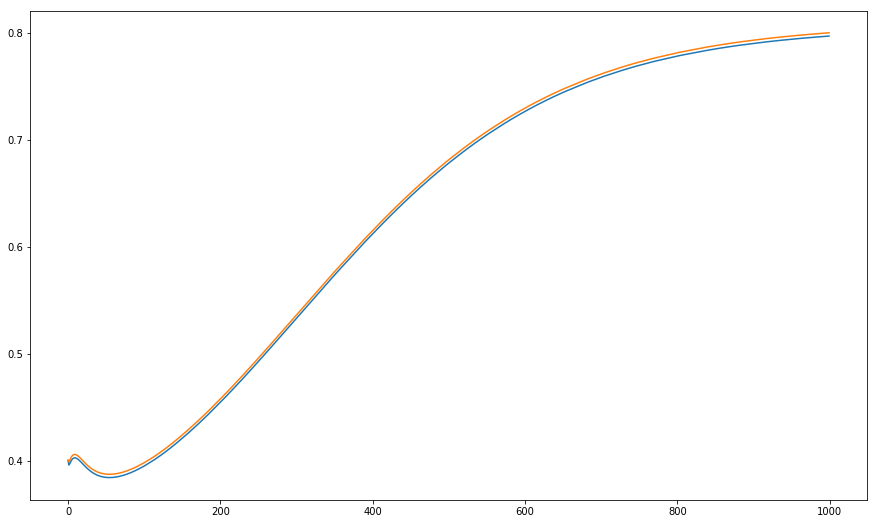

<Figure size 432x288 with 0 Axes>

In [4]:
from __future__ import division

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import time
start_time = time.time()

class SGDModel:
    def __init__(self):
        self.model = linear_model.SGDClassifier(warm_start=True, max_iter=5, tol=-np.infty)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

class PerceptronModel:
    def __init__(self):
        self.model = linear_model.Perceptron(warm_start=True, max_iter=5, tol=-np.infty)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class LogisticRegression:
    def __init__(self):
        self.model = linear_model.LogisticRegression(warm_start=True, solver='sag')

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)
    
class LinearRegression:
    def __init__(self):
        self.model = linear_model.LinearRegression()

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    
if __name__ == "__main__":

    # # linear problem
    # odefun                    = lambda y: -y/2
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0, 1.0]
    # y0                        = [2, 1.0]

    # oscillatory problem
    # odefun                    = lambda y: [-np.sin(y[2]), -100 * np.sin(100*y[2]), 1] 
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0.0, 2 * math.pi]
    # y0                        = [1.0, 1.0, 0]
    
    # Allen Cahn
    #import allen_cahn as ac
    model                     = InitializeModel()
    odefun                    = lambda y: model['rhsFun'](y)
    #odefun                    = lambda y: [-np.sin(y[2]),-100 * np.sin(100*y[2]),1]
    options                   = {}
    options['abstol']         = 1.0e-8
    options['reltol']         = 1.0e-8
    options['numcheckpoints'] = 1000
    options['nobservations']  = 25
    options['model']          = LinearRegression()
    options['nvalidation']    = 10
    options['valthreshold']   = 0.60
    options['shrinkfactor']   = 0.8
    options['maxshrinks']     = 5
    options['nsamples']       = 5
    tspan                     = [0.0, 0.3]
    #tspan                     = [0, 1.0]
    #y0                        = [2, 1.0,0]
    y0                        = model['y0']

    trajectory                = rk45(odefun, tspan, y0, options)
    
    # print number of accepted/rejected steps
    print("Accepted Steps:" + str(options['nacc']))
    print("Rejected Steps:" + str(options['nrej']))
    print("Time: %s seconds" % (time.time() - start_time))
    # Plot trajectory
    n = len(y0)

    # create a figure
    plt.figure(figsize=(15,9))
    
    for i in range(2):
        plt.plot(trajectory[i, :])

    plt.show()
    plt.savefig('graph')
